In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.nn import Parameter
from enum import IntEnum
import os
import numpy as np
m=500
n=100
lam=0.1
target_size=(10,10)
tot_dataimg_size=40000
batch=100
batchsize=64
epoch=50

## Load Data and process 

In [4]:
training_data = datasets.EMNIST(
    root="data",
    train=True,
    download=True,
    split='byclass',
    transform = transforms.Compose([
    transforms.Resize(target_size),  # 调整大小
    transforms.ToTensor()  # 转换为PyTorch张量
])
)

test_data = datasets.EMNIST(
    root="data",
    train=False,
    download=True,
    split='byclass',
    transform = transforms.Compose([
    transforms.Resize(target_size),  # 调整大小
    transforms.ToTensor()  # 转换为PyTorch张量
])
)

In [5]:
num_class=len(training_data.classes)
num_class

62

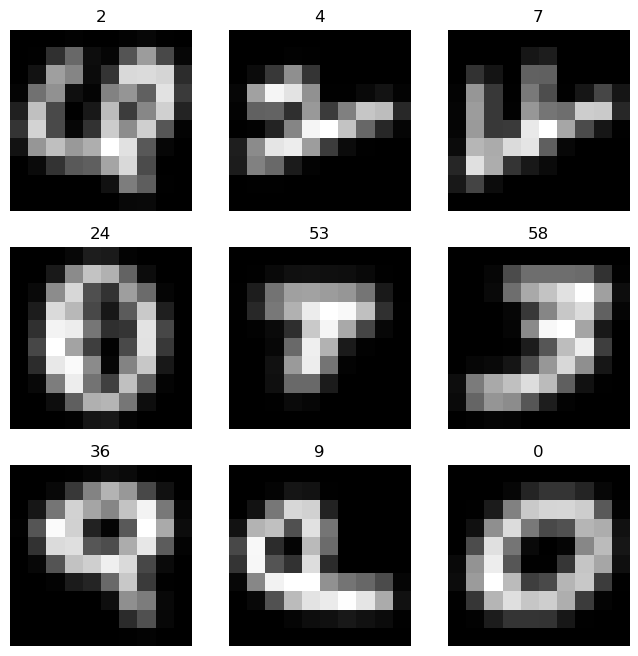

In [3]:
import matplotlib
from matplotlib import pyplot as plt
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## form balanced_class training set

In [24]:
path_base='data'
if not os.path.exists(path_base):
    print('No data')
for num,i in enumerate(training_data):
    path=os.path.join(path_base,str(i[1]))
    if not os.path.exists(path):
        os.mkdir(path)
    torch.save(i[0],os.path.join(path, str(num)))
   # if os.path.exists(path)

In [5]:
from sklearn.utils import resample

In [ ]:
num_samples_to_generate=batch*batchsize*epoch

In [27]:
numforclass=int(np.ceil(tot_dataimg_size/num_class))
path_base='data'
path_baseb='data_balanced'
if not os.path.exists(path_baseb):
    os.mkdir(path_baseb)
if not os.path.exists(path_base):
    print('No data')
for i in range(num_class):
    path=os.path.join(path_base,str(i))
    pathn=os.path.join(path_baseb,str(i))
    if not os.path.exists(pathn):
        os.mkdir(pathn)
    rebalence=resample(os.listdir(path),n_samples=numforclass)
    for j in rebalence:
        tmp=torch.load(os.path.join(path,j))
        torch.save(tmp,os.path.join(pathn,j))
   # if os.path.exists(path)

In [107]:
sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]
print(img.size())

torch.Size([1, 10, 10])


In [14]:
len(test_data.train_labels)

116323

In [8]:
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 10, 10])
Labels batch shape: torch.Size([64])


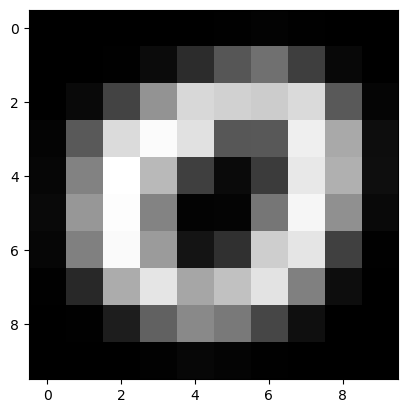

Label: 0


In [7]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Define BFGS ans SR1 

In [76]:
def H_BFGS(H,x,x_past,size):

    x_del = x - x_past
    s = x_del[:size//2]
    y = x_del[size//2:]

    sty=torch.matmul(s,y.t())
    syt=torch.matmul(s.t(),y)
    yst=torch.matmul(y.t(),s)
    sst=torch.matmul(s.t(),)

    H_bfgs =  H-(torch.matmul(syt,H)+torch.matmul(H,yst)+(torch.matmul(y,torch.matmul(H,y.t()))/yts+1)*sst)/yts

    return H_bfgs

def H_SR1(H,x,x_past,size):

    x_del = x - x_past
    s = x_del[:size//2]
    y = x_del[size//2:]
    Hy_s = torch.matmul(H,y.t())-s.t()

    H_sr1 =  H-torch.matmul(Hy_s,Hy_s.t())/torch.matmul(Hy_s.t(),y.t())

    return H_sr1

## define objective function

In [ ]:
class LSTM_Relat(nn.Module):
    """
    自己构造的LSTM
    等价于nn.LSTM中batch_first=True的效果
    """
    def __init__(self, input_size, hidden_size,unfold_size,A,b):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.unfold_size=unfold_size
        # train_parameter for tuta
        self.tuta = Parameter(torch.Tensor(unfold_size))
        # 输入门i_t
        self.W_i = Parameter(torch.Tensor(input_size, hidden_size))
        self.U_i = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_i = Parameter(torch.Tensor(hidden_size))
        # 遗忘门f_t
        self.W_f = Parameter(torch.Tensor(input_size, hidden_size))
        self.U_f = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_f = Parameter(torch.Tensor(hidden_size))
        # 候选内部状态g_t
        self.W_g = Parameter(torch.Tensor(input_size, hidden_size))
        self.U_g = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_g = Parameter(torch.Tensor(hidden_size))
        # 输出门o_t
        self.W_o = Parameter(torch.Tensor(input_size, hidden_size))
        self.U_o = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_o = Parameter(torch.Tensor(hidden_size))
        
        # train_parameter for theta
        self.theta = Parameter(torch.Tensor(unfold_size))
        # 输入门i_t
        self.Wt_i = Parameter(torch.Tensor(input_size, hidden_size))
        self.Ut_i = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bt_i = Parameter(torch.Tensor(hidden_size))
        # 遗忘门f_t
        self.Wt_f = Parameter(torch.Tensor(input_size, hidden_size))
        self.Ut_f = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bt_f = Parameter(torch.Tensor(hidden_size))
        # 候选内部状态g_t
        self.Wt_g = Parameter(torch.Tensor(input_size, hidden_size))
        self.Ut_g = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bt_g = Parameter(torch.Tensor(hidden_size))
        # 输出门o_t
        self.Wt_o = Parameter(torch.Tensor(input_size, hidden_size))
        self.Ut_o = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bt_o = Parameter(torch.Tensor(hidden_size))

        # 初始化参数
        self._initialize_weights()

    def _initialize_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def func():
        #TODO initialize the function to finish LSTM
    
    
    def _init_states(self, x):
        h_t = torch.zeros(1, x.size(0), self.hidden_size, dtype=x.dtype).to(x.device)
        c_t = torch.zeros(1, x.size(0), self.hidden_size, dtype=x.dtype).to(x.device)
        return h_t, c_t

    def forward(self, x, init_states=None):
        """
        在这里我定义x的输入格式是(batch, sequence, feature)
        """
        batch_size, n2 = x.size()
        n=n2//2
        hidden_seq_tuta = []
        hidden_seq_theta=[]
        x_recom = torch.zeros([batch_size,self.unfold_size,_])
        H=torch.eye(n)
        
        # 状态初始化
        if init_states is None:
            h_t, c_t = self._init_states(x)
        else:
            h_t, c_t = init_states
        x_t=x
        # 按时间顺序迭代
        for t in range(self.unfold_size):
            if t > 0:
                # 更新门组件及内部候选状态（Tips:Pytorch中@用于矩阵相乘，*用于逐个元素相乘）
                # for tuta
                i_t = torch.sigmoid(x_t @ self.W_i + self.b_i*h_t)
                f_t = torch.sigmoid(x_t @ self.W_f + self.b_f*h_t)
                g_t = torch.tanh(x_t @ self.W_g + self.b_g*h_t)
                o_t = torch.sigmoid(x_t @ self.W_o + self.b_o*h_t)
                # 记忆单元和隐藏单元更新
                c_t = f_t * c_t + i_t * g_t
                h_t = o_t * torch.tanh(c_t)
                hidden_seq_tuta.append(h_t)
                H1=H_BFGS(Hk,x_t,x_bef,n)
                H2=H_SR1(Hk,x_t,x_bef,n)
                Hk=h_t*H1+(1-h_t)*H2
            
            # for theta
            it_t = torch.sigmoid(x_t @ self.Wt_i + self.bt_i*ht_t)
            ft_t = torch.sigmoid(x_t @ self.Wt_f + self.b_f*ht_t)
            gt_t = torch.tanh(x_t @ self.Wt_g + self.bt_g*ht_t)
            ot_t = torch.sigmoid(x_t @ self.Wt_o + self.bt_o*ht_t)
            # 记忆单元和隐藏单元更新
            ct_t = ft_t * ct_t + it_t * gt_t
            t = ot_t * torch.tanh(ct_t)
            hidden_seq_theta.append(ht_t)
            
            p=-torch.matmul()
            x_bef=x_t
            x_t=
            
            
        hidden_seq = torch.cat(hidden_seq, dim=Dim.batch)
        hidden_seq = hidden_seq.transpose(Dim.batch, Dim.seq).contiguous()
        return hidden_seq, (h_t, c_t)
